<a href="https://colab.research.google.com/github/oecorrechag/neural-network-tensorflow/blob/main/notebooks/class%2027%20-%20transfer_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIMS

Ejemplo de red neuronal con transfer learning with keras

https://keras.io/api/applications/

In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import string
import pandas as pd
import time
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNet

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

## Cargar el train y test

In [82]:
# !wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip \
#     -O sign-language-img.zip

In [83]:
# Descomprimimos
local_zip = '/tmp/sign-language-img.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/sign-language-img')
zip_ref.close()

In [84]:
train_dir = "/tmp/sign-language-img/Train"
test_dir = "/tmp/sign-language-img/Test"

## Data Generators

In [85]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split= 0.2)

In [86]:
train_generator_resize = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "training"
)

validation_generator_resize = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "validation"
)

test_generator_resize = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb"
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


## Definir las clases

Recordar que hay dos letras que no tenemos J y Z

In [87]:
classes = [char for char in string.ascii_uppercase if char != "J" if char != "Z"]
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

## Generate model

In [88]:
pre_trained_model = InceptionV3(
    include_top = False,                                         # no se quiere la ultima capa del modelo
    input_tensor = tf.keras.layers.Input(shape = (150, 150, 3))  # tamaño de ingreso
)

# no me entrene el modelo, ya que vamos a usar un modelo ya entrenado
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [89]:
# congelar hasta la capa 7 y agregar nuestra capa de salida
last_layers = pre_trained_model.get_layer("mixed7")
last_output = last_layers.output

In [90]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(classes), activation= "softmax")(x)

# une el modelo pre entrenado y lo anterior
model_keras = tf.keras.Model(pre_trained_model.input, x)

model_keras.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model_keras.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

## Training

Entrenemos durante 20 épocas. Esto puede tardar unos minutos en ejecutarse.

In [91]:
history_keras = model_keras.fit(
    train_generator_resize,
    epochs = 5,
    validation_data = validation_generator_resize
)

Epoch 1/5
215/215 [==============================] - 39s 153ms/step - loss: 0.1272 - accuracy: 0.9643 - val_loss: 0.0908 - val_accuracy: 0.9663
Epoch 2/5
215/215 [==============================] - 31s 146ms/step - loss: 0.0068 - accuracy: 0.9986 - val_loss: 0.0743 - val_accuracy: 0.9761
Epoch 3/5
215/215 [==============================] - 32s 147ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0556 - val_accuracy: 0.9825
Epoch 4/5
215/215 [==============================] - 31s 144ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.1797 - val_accuracy: 0.9691
Epoch 5/5
215/215 [==============================] - 32s 147ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0905 - val_accuracy: 0.9825


## Testing

In [92]:
results = model_keras.evaluate(test_generator_resize)

57/57 [==============================] - 8s 131ms/step - loss: 0.0841 - accuracy: 0.9815


## Summary model

In [93]:
def visualizacion_resultados(history):
    epochs = [i for i in range(5)]
    fig, ax = plt.subplots(1,2)
    train_acc = history.history["accuracy"]
    train_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]
    fig.set_size_inches(16, 9)

    ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
    ax[0].plot(epochs, val_acc, "ro-", label= "Validacion accuracy")
    ax[0].set_title("Entrenamiento & validación accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
    ax[1].plot(epochs, val_loss, "ro-", label= "Validacion Loss")
    ax[1].set_title("Entrenamiento & validación Loss")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.show()

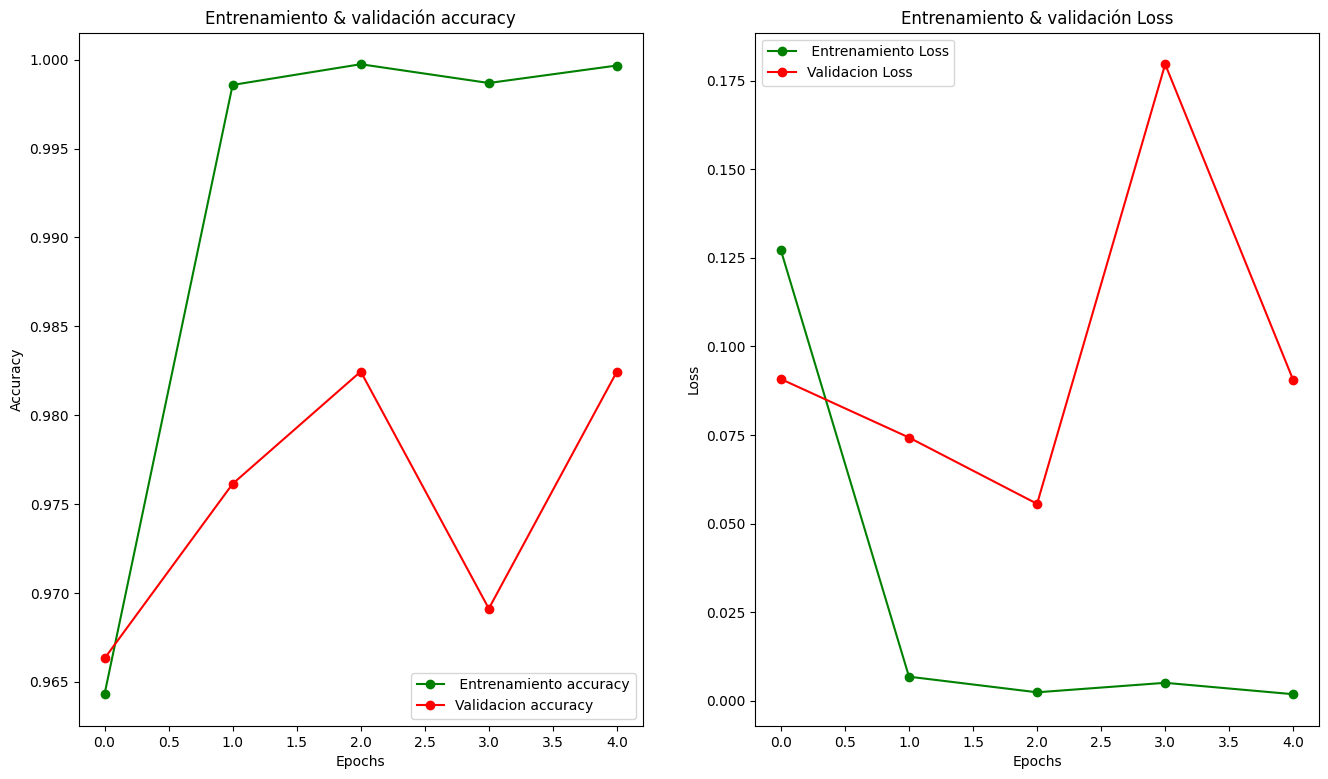

In [94]:
visualizacion_resultados(history_keras)

# Actividad 2

In [104]:
pre_trained_model2 = MobileNet(weights='imagenet', include_top=False)

In [113]:
x = pre_trained_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Agregar capas densas según sea necesario
predictions = Dense(24, activation='softmax')(x)  # Capa densa de salida con 24 clases

In [114]:
model_keras2 = tf.keras.Model(inputs=pre_trained_model2.input, outputs=predictions)

In [115]:
# Compilar el modelo
model_keras2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_keras2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                   

In [116]:
history_keras2 = model_keras2.fit(
    train_generator_resize,
    epochs = 5,
    validation_data = validation_generator_resize
)

Epoch 1/5
215/215 [==============================] - 34s 139ms/step - loss: 0.3658 - accuracy: 0.9036 - val_loss: 0.1583 - val_accuracy: 0.9523
Epoch 2/5
215/215 [==============================] - 33s 152ms/step - loss: 0.0236 - accuracy: 0.9979 - val_loss: 0.1186 - val_accuracy: 0.9607
Epoch 3/5
215/215 [==============================] - 29s 136ms/step - loss: 0.0092 - accuracy: 0.9996 - val_loss: 0.0851 - val_accuracy: 0.9747
Epoch 4/5
215/215 [==============================] - 29s 136ms/step - loss: 0.0051 - accuracy: 0.9999 - val_loss: 0.0699 - val_accuracy: 0.9775
Epoch 5/5
215/215 [==============================] - 31s 142ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0753 - val_accuracy: 0.9796


In [117]:
results = model_keras2.evaluate(test_generator_resize)

57/57 [==============================] - 7s 127ms/step - loss: 0.0659 - accuracy: 0.9810


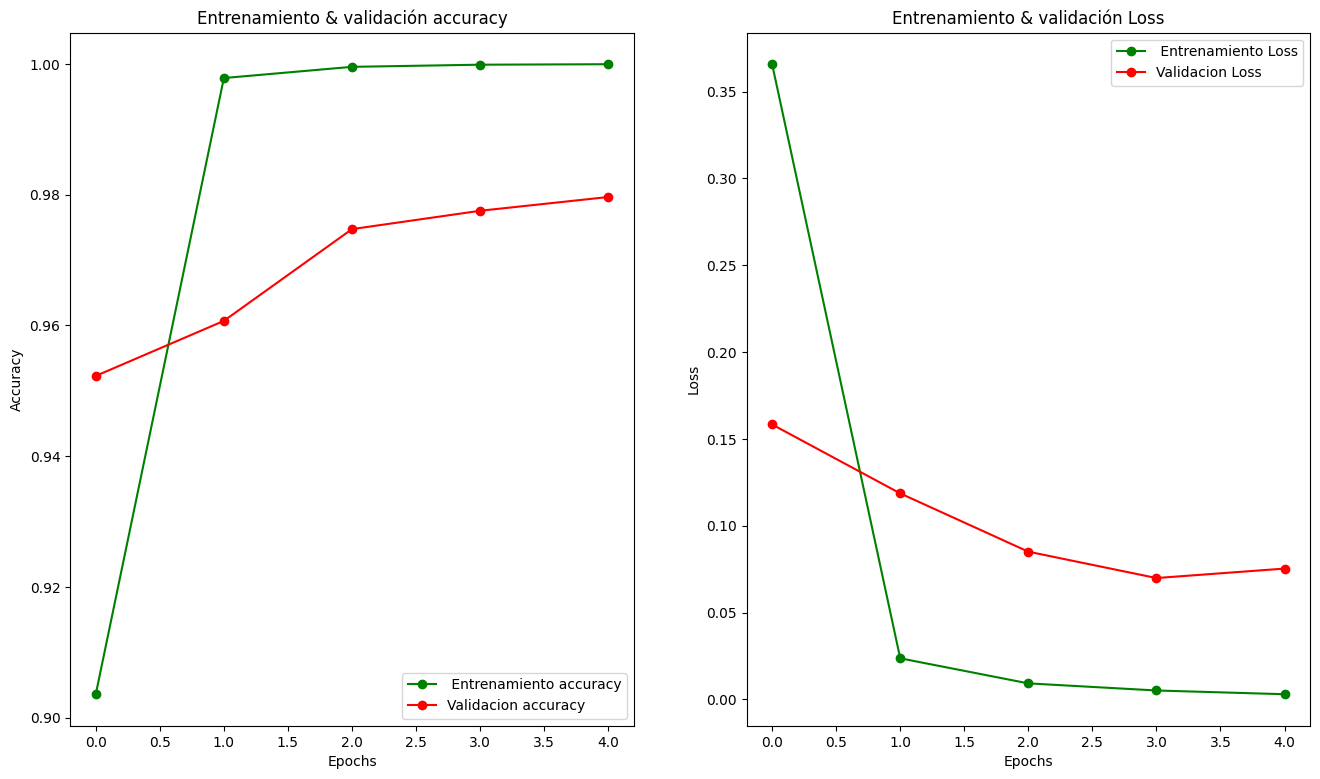

In [118]:
visualizacion_resultados(history_keras2)

In [119]:
print('Ok_')

Ok_
